In [1]:
import numpy as np
import pandas as pd
import histogrammar as hg
import matplotlib.pyplot as plt

In [2]:
import matplotlib

In [3]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from scipy.stats import chi2, norm


In [4]:
%matplotlib inline

In [5]:
plt.rc('font', size=12)

In [6]:
# generate fake y and y_prob

In [21]:
np.random.seed(42)

In [22]:
# real y and y_prob

In [29]:
# generate 2 class dataset
X_gen, y_gen = make_classification(n_samples=211000, n_classes=2, random_state=1, n_features=30)

X_score, X_truth, X = X_gen[:10_000], X_gen[10_000: 210_000], X_gen[210_000:]
y_score, y_truth, y = y_gen[:10_000], y_gen[10_000: 210_000], y_gen[210_000:]

In [30]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)


LogisticRegression()

In [31]:
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)

precision, recall, thresholds = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(recall, precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))


Logistic: f1=0.923 auc=0.968


In [32]:
# predict probabilities
lr_probsB = model.predict_proba(X_truth)
# keep probabilities for the positive outcome only
lr_probsB = lr_probsB[:, 1]

precisionB, recallB, thresholdsB = precision_recall_curve(y_truth, lr_probsB)


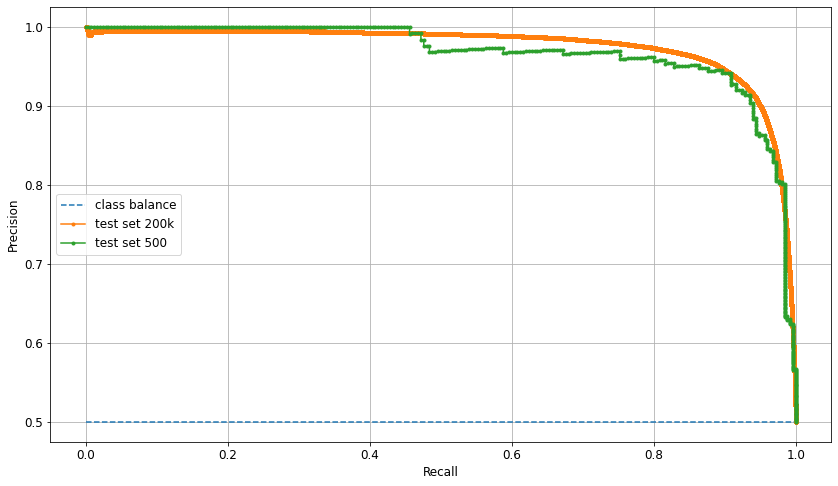

In [33]:
# plot the precision-recall curves
plt.figure(figsize=(14,8))
no_skill = 0.5

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='class balance')
plt.plot(recallB, precisionB, marker='.', label='test set 200k', )
plt.plot(recall, precision, marker='.', label='test set 500')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.grid()
# show the plot
plt.show()

In [34]:
from tqdm import tqdm

In [35]:
lr_probs_s = model.predict_proba(X_score)[:, 1]
lr_probs_s = np.sort(lr_probs_s)

lr_probs_t = model.predict_proba(testX)[:, 1]
thresholds = lr_probs_t.copy()
thresholds = np.sort(lr_probs_t.copy())


In [37]:
P = []
R = []

for threshold in tqdm(thresholds):
    ss_gt = lr_probs_s[lr_probs_s >= threshold]
    ss_lt = lr_probs_s[lr_probs_s < threshold]

    keep_gt = lr_probs_t >= threshold
    keep_lt = lr_probs_t < threshold
    ts_gt = lr_probs_t[keep_gt]
    ty_gt = testy[keep_gt]
    ts_lt = lr_probs_t[keep_lt]
    ty_lt = testy[keep_lt]
    
    prec_gt = np.sum(ss_gt) / len(ss_gt) - np.sum(ts_gt - ty_gt) / len(ty_gt)
    prec_lt = np.sum(ss_lt) / len(ss_lt) - np.sum(ts_lt - ty_lt) / len(ty_lt)
    ratio = len(ss_lt) / len(ss_gt)

    rec = prec_gt / (prec_lt * ratio + prec_gt)
    
    P.append( prec_gt )
    R.append( rec )

P = P[::-1]
R = R[::-1]

  0%|                                                                                                                                            | 0/500 [00:00<?, ?it/s]/var/folders/pr/95qqk09n3l1dzzv4603_h7lc0000gn/T/ipykernel_31981/3294437503.py:16: RuntimeWarning: invalid value encountered in double_scalars
  prec_lt = np.sum(ss_lt) / len(ss_lt) - np.sum(ts_lt - ty_lt) / len(ty_lt)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 12342.58it/s]


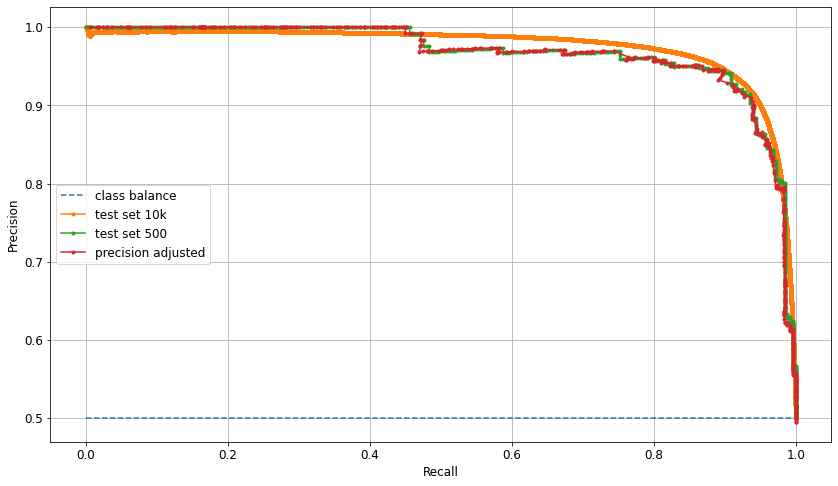

In [38]:
# plot the precision-recall curves
plt.figure(figsize=(14,8))
no_skill = 0.5

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='class balance')
plt.plot(recallB, precisionB, marker='.', label='test set 10k', )
plt.plot(recall, precision, marker='.', label='test set 500')
plt.plot(R, P, marker='.', label='precision adjusted')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.grid()
# show the plot
plt.show()

In [133]:
np.sum(lr_probs - testy) / len(testy)

0.010564373222377889

In [134]:
lr_probsC = model.predict_proba(X_score)[:, 1]

In [135]:
np.sum(lr_probsC) / len(lr_probsC) - np.sum(lr_probs - testy) / len(testy)

0.5034985107792539

In [136]:
np.std(lr_probsC, ddof=1)

0.3974760414440774

In [138]:
np.sum(testy) / len(testy)

0.516

In [139]:
frac = np.sum(testy) / len(testy)
frac

0.516

In [140]:
np.sqrt(frac*(1-frac)/ len(testy))

0.022349228174592516

In [151]:
ce = np.std(testy, ddof=1) / np.sqrt(len(testy))
ce

0.02237161098258039

In [142]:
ae = np.std(lr_probs - testy, ddof=1) / np.sqrt(len(testy))

In [143]:
be = np.std(lr_probsC, ddof=1) / np.sqrt(len(lr_probsC))

In [144]:
ae, be

(0.01392852215836916, 0.003974760414440774)

In [149]:
ae, np.sqrt(ae**2 + be**2)

(0.01392852215836916, 0.01448455901532339)

In [152]:
ae**-2 / ce**-2

2.5797904978634376

In [146]:
# pick a set

In [147]:
if False:
    y_true = y
    y_prob = X

In [148]:
y_true = testy # [testy==1]
y_prob = lr_probs # [testy==1]


In [98]:
y_true = y_true.astype(int)

In [99]:
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

In [16]:
# add zero threshold (missing by default?)
thresholds = np.concatenate([[0.], thresholds])

In [17]:
#############################
# Calculate Uncertainty bands

N = len(y_true)

# Getting TP, FN, FP
# remark: computing them with metrics.confusion_matrix() takes too much time
P = np.array([sum(y_true)] * len(thresholds))
# we use ">= thr" like in precision_recall_curve():
TP = np.array([((y_prob >= thr) & y_true).sum() for thr in thresholds])
PP = np.array([(y_prob >= thr).sum() for thr in thresholds])
FN = P - TP
FP = PP - TP

In [18]:
recall = TP / (TP + FN)
precision = TP / (TP + FP)

In [19]:
# Partial derivatives
# tpr == recall = TP/P = TP/(TP + FN)
# precision == positive predictive value = TP/PP = TP/(TP + FP)
d_recall_d_TP = FN / (FN + TP)**2
d_recall_d_FN = - TP / (FN + TP)**2
d_precision_d_TP = FP / (FP + TP)**2
d_precision_d_FP = - TP / (FP + TP)**2

In [20]:
def zero_to_one(x, value=0):
    xp = x.copy().astype(float)
    xp[xp == 0] = value
    return xp

var_TP = N * (zero_to_one(TP)/N) * (1 - (zero_to_one(TP)/N))
var_FN = N * (zero_to_one(FN)/N) * (1 - (zero_to_one(FN)/N))
var_FP = N * (zero_to_one(FP)/N) * (1 - (zero_to_one(FP)/N))

covar_TPFP = -N * (zero_to_one(TP)/N) * (zero_to_one(FP)/N)
covar_TPFN = -N * (zero_to_one(TP)/N) * (zero_to_one(FN)/N)
covar_FPFN = -N * (zero_to_one(FP)/N) * (zero_to_one(FN)/N)

var_precision = (d_precision_d_TP ** 2) * var_TP + (d_precision_d_FP ** 2) * var_FP + 2 * d_precision_d_TP * d_precision_d_FP * covar_TPFP
var_recall = (d_recall_d_TP ** 2) * var_TP + (d_recall_d_FN ** 2) * var_FN + 2 * d_recall_d_TP * d_recall_d_FN * covar_TPFN
covar_recall_precision = d_recall_d_TP * d_precision_d_TP * var_TP + d_recall_d_TP * d_precision_d_FP * covar_TPFP + d_recall_d_FN * d_precision_d_TP * covar_TPFN + d_recall_d_FN * d_precision_d_FP * covar_FPFN

#corrl_recall_precision = covar_recall_precision / np.sqrt(var_recall * var_precision)

# Angle and lambdas
# based on https://cookierobotics.com/007/ :
a = var_recall  # cov[0][0]
c = var_precision  # cov[1][1]
b = covar_recall_precision  # cov[1][0]

lambda1 = (a+c)/2 + np.sqrt(((a-c)/2)**2 + b**2)
lambda2 = (a+c)/2 - np.sqrt(((a-c)/2)**2 + b**2)

def calculate_theta(lambda1, a, b, c):
    if b == 0 and a >= c:
        return 0.
    elif b == 0 and a < c:
        return np.pi / 2.
    else:
        return np.arctan2(lambda1 - a, b)

theta = np.vectorize(calculate_theta)(lambda1, a, b, c)
angle = theta / np.pi * 180

# Radii of the ellipse
recall_r = np.sqrt(lambda1)
precision_r = np.sqrt(lambda2)


# Get the scale for 2 degrees of freedom confidence interval
# We use chi2 because the equation of an ellipse is a sum of squared variable,
# more details here https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
norm_nstd = 1  # number of standard deviation
norm_pct = 2. * (norm.cdf(norm_nstd) - 0.5)
chi2_quantile = chi2.ppf(norm_pct, 2)

# 90% CL 
chi2_quantile = chi2.ppf(0.9, 2)
scale = np.sqrt(chi2_quantile)


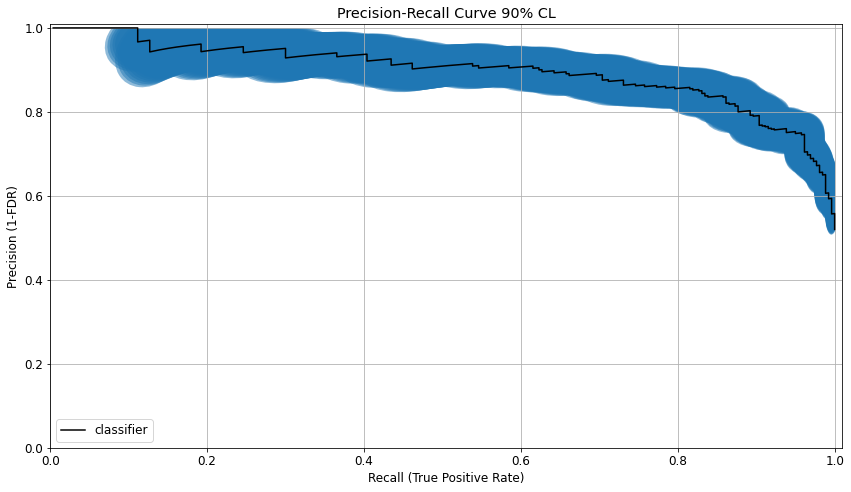

In [22]:
fig, ax = plt.subplots(figsize=(12, 7))

# For each point in the precision-recall curve plot an ellipse
for i, (r, p, r_r, p_r, a) in enumerate(zip(recall, precision, recall_r, precision_r, angle)):
    # we multiply the radius by 2 because width and height are diameters
    ellipse = matplotlib.patches.Ellipse(
        (r, p), width=2*scale*r_r, height=2*scale*p_r, angle=a, alpha=0.5) # adjust_lightness(cmap(0), 1.5))
    ax.add_patch(ellipse)

if False:
    idx = -36
    r, p, r_r, p_r, a = recall[idx], precision[idx], recall_r[idx], precision_r[idx], angle[idx]
    ellipse = matplotlib.patches.Ellipse((r, p), width=2*scale*r_r, height=2*scale*p_r, angle=a, alpha=0.5, color='orange')
    ax.add_patch(ellipse)

    r, p, r_r, p_r, a = recall[40], precision[40], recall_r[40], precision_r[40], angle[40]
    ellipse = matplotlib.patches.Ellipse((r, p), width=2*scale*r_r, height=2*scale*p_r, angle=a, alpha=0.5, color='orange')
    ax.add_patch(ellipse)

    r, p, r_r, p_r, a = recall[int(N/2)], precision[int(N/2)], recall_r[int(N/2)], precision_r[int(N/2)], angle[int(N/2)]
    ellipse = matplotlib.patches.Ellipse((r, p), width=2*scale*r_r, height=2*scale*p_r, angle=a, alpha=0.5, color='orange')
    ax.add_patch(ellipse)

# Plot precision-recall curve
cmap = plt.get_cmap("tab10")
ax.plot(recall, precision, label='classifier', color='black')

rec1 = matplotlib.patches.Rectangle([0, 1.], 1.01, 0.1, ec="none", color = 'white')
rec2 = matplotlib.patches.Rectangle([1, 0.], 0.1, 1.01, ec="none", color = 'white')
ax.add_patch(rec1)
ax.add_patch(rec2)

ax.set_xlim((0, 1.01))
ax.set_ylim((0, 1.01))
ax.set_xlabel('Recall (True Positive Rate)')
ax.set_ylabel('Precision (1-FDR)')
#ax.set_title(f'Precision-Recall Curve ±1σ')
ax.set_title(f'Precision-Recall Curve 90% CL')
ax.legend(loc="lower left")
ax.grid()

plt.tight_layout()
plt.savefig('PR_uncertainties.pdf')
